## P7 - Prep the data 

---

In [ ]:
import random
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from rich.pretty import pprint
import warnings

warnings.filterwarnings("ignore")


In [248]:
%load_ext rich

---

## Kernel Kaggle

In [89]:
# Fonction Cleaning Finale
def cleaning(features, test_features, encoding="ohe"):
    """Fonction cleaning finale"""
    # Extract the ids
    train_ids = features["SK_ID_CURR"]
    test_ids = test_features["SK_ID_CURR"]

    # Extract the labels for training
    labels = features["TARGET"]

    # Remove the ids and target
    features = features.drop(columns=["SK_ID_CURR", "TARGET"])
    test_features = test_features.drop(columns=["SK_ID_CURR"])

    # One Hot Encoding
    if encoding == "ohe":
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)

        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join="inner", axis=1)

        # No categorical indices to record
        cat_indices = "auto"

    # Integer label encoding
    elif encoding == "le":
        # Create a label encoder
        label_encoder = LabelEncoder()

        # List for storing categorical indices
        cat_indices = []

        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == "object":
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(
                    np.array(features[col].astype(str)).reshape((-1,))
                )
                test_features[col] = label_encoder.transform(
                    np.array(test_features[col].astype(str)).reshape((-1,))
                )

                # Record the categorical indices
                cat_indices.append(i)

    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")

    print("Training Data Shape: ", features.shape)
    print("Testing Data Shape: ", test_features.shape)

    # Extract feature names
    feature_names = list(features.columns)

    # Impute the domainnomial features
    imputer = SimpleImputer(strategy="median")

    features = imputer.fit_transform(features)
    test_features = imputer.transform(test_features)

    # Scale the domainnomial features
    scaler = MinMaxScaler(feature_range=(0, 1))

    features = scaler.fit_transform(features)
    test_features = scaler.transform(test_features)

    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)

    return feature_names, labels, features, test_features, train_ids, test_ids


In [91]:
# Training data
app_train = pd.read_csv("../../data/raw/application_train.csv")
print("Training data shape: ", app_train.shape)
app_train.head(2)

# Testing data features
app_test = pd.read_csv("../../data/raw/application_test.csv")
print("Testing data shape: ", app_test.shape)
app_test.head(2)

# copy to add fe
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

# feature engineering with domain knowledge variables
app_train_domain["CREDIT_INCOME_PERCENT"] = (
    app_train_domain["AMT_CREDIT"] / app_train_domain["AMT_INCOME_TOTAL"]
)
app_train_domain["ANNUITY_INCOME_PERCENT"] = (
    app_train_domain["AMT_ANNUITY"] / app_train_domain["AMT_INCOME_TOTAL"]
)
app_train_domain["CREDIT_TERM"] = (
    app_train_domain["AMT_ANNUITY"] / app_train_domain["AMT_CREDIT"]
)
app_train_domain["DAYS_EMPLOYED_PERCENT"] = (
    app_train_domain["DAYS_EMPLOYED"] / app_train_domain["DAYS_BIRTH"]
)

app_test_domain["CREDIT_INCOME_PERCENT"] = (
    app_test_domain["AMT_CREDIT"] / app_test_domain["AMT_INCOME_TOTAL"]
)
app_test_domain["ANNUITY_INCOME_PERCENT"] = (
    app_test_domain["AMT_ANNUITY"] / app_test_domain["AMT_INCOME_TOTAL"]
)
app_test_domain["CREDIT_TERM"] = (
    app_test_domain["AMT_ANNUITY"] / app_test_domain["AMT_CREDIT"]
)
app_test_domain["DAYS_EMPLOYED_PERCENT"] = (
    app_test_domain["DAYS_EMPLOYED"] / app_test_domain["DAYS_BIRTH"]
)

# Create an anomalous flag column
app_train_domain["DAYS_EMPLOYED_ANOM"] = app_train_domain["DAYS_EMPLOYED"] == 365243
# Replace the anomalous values with nan
app_train_domain["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace=True)

app_test_domain["DAYS_EMPLOYED_ANOM"] = app_test_domain["DAYS_EMPLOYED"] == 365243
app_test_domain["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace=True)


app_train_domain["DAYS_EMPLOYED_ANOM"] = app_train_domain["DAYS_EMPLOYED_ANOM"].astype(
    "int32"
)
app_test_domain["DAYS_EMPLOYED_ANOM"] = app_test_domain["DAYS_EMPLOYED_ANOM"].astype(
    "int32"
)

Training data shape:  (307511, 122)
Testing data shape:  (48744, 121)


In [92]:
liste_features, y_train, X_train, X_test, train_ids, test_ids = cleaning(
    app_train_domain, app_test_domain, encoding="ohe"
)
train_final = pd.DataFrame(X_train, columns=liste_features)
train_final["LABELS"] = y_train
train_final["SK_ID_CURR"] = train_ids

test_final = pd.DataFrame(X_test, columns=liste_features)
test_final["SK_ID_CURR"] = test_ids


Training Data Shape:  (307511, 246)
Testing Data Shape:  (48744, 246)


We create a test and train set from the train and test set we obtain.  

We don't have true label for the test set, thus we will use the train set to train and evaluate our models.  
To do so, we split it into train and test.  
We will create **X_train_split**, **y_train_split**, **X_val** and **y_val**

In [93]:
from sklearn.model_selection import train_test_split

X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)


---

## Models

In [94]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

### Models scores

In [8]:
from sklearn.metrics import (
    make_scorer,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

scoring = {
    "roc_auc": make_scorer(roc_auc_score),
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "f1": make_scorer(f1_score),
}


In [ ]:
def my_custom_loss_func(y_true, y_pred):
    diff = np.abs(y_true - y_pred).max()

    return np.log1p(diff)


# score will negate the return value of my_custom_loss_func,

# which will be np.log(2), 0.693, given the values for X

# and y defined below.

score = make_scorer(my_custom_loss_func, greater_is_better=False)

---

### SMOTE

In [8]:
from imblearn.over_sampling import SMOTE


smote = SMOTE(random_state=42)
X_train_split_resampled, y_train_split_resampled = smote.fit_resample(
    X_train_split, y_train_split
)

# Check the new class distribution
print("Original class distribution:", pd.Series(y_train).value_counts())
print(
    "Resampled class distribution:", pd.Series(y_train_split_resampled).value_counts()
)

Original class distribution: TARGET
0    282686
1     24825
Name: count, dtype: int64
Resampled class distribution: TARGET
0    189324
1    189324
Name: count, dtype: int64


---

---

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer, fbeta_score


# Model class
class Model:
    def __init__(self, name, estimator, params):
        """
        Parameters:
        - name: str, name of the model
        - estimator: sklearn estimator object
        - params: dict, parameters for grid search
        """

        self.name = name
        self.estimator = estimator
        self.params = params
        self.best_model = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    def load_data(self, X_train, X_test, y_train, y_test):
        """Load training and testing data."""
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

    def find_best_params(self, cv=5, beta=10, method="grid"):
        """
        Use GridSearchCV to find the best parameters.
        """
        self.beta = beta

        if self.X_train is None or self.y_train is None:
            raise ValueError("Data not loaded yet. Call load_data first.")

        # We want to maximize fbeta_score with gridsearchcv
        fbeta_scorer = make_scorer(fbeta_score, beta=beta)

        if method == "grid_search":
            param_grid = {
                param: config["values"] for param, config in self.params.items()
            }

            search = GridSearchCV(
                estimator=self.estimator,
                param_grid=param_grid,
                cv=cv,
                # scoring=fbeta_score(self.y_train, beta=10),
                scoring=fbeta_scorer,
                n_jobs=6,
            )

        elif method == "random_search":
            param_distributions = {}
            for param, config in self.params.items():
                if config["type"] == "int":
                    param_distributions[param] = randint(
                        config["min"], config["max"] + 1
                    )
                elif config["type"] == "float":
                    param_distributions[param] = uniform(
                        config["min"], config["max"] - config["min"]
                    )

            search = RandomizedSearchCV(
                estimator=self.estimator,
                param_distributions=param_distributions,
                cv=cv,
                # scoring=fbeta_score(self.y_train, beta=10),
                scoring=fbeta_scorer,
                n_iter=1,
                n_jobs=-4,
            )

        else:
            raise ValueError(
                "search_type must be 'grid_search' or 'random_search' for GridSearchCV or RandomizedSearchCV"
            )

        search.fit(self.X_train, self.y_train)
        self.best_model = search.best_estimator_

        return {
            "best_params": search.best_params_,
            "best_score": search.best_score_,
        }

    def evaluate(self, metrics=None):
        """
        Evaluate the best model on the test set using multiple metrics.

        Parameters:
        metrics : List of metric names to calculate'

        Returns:
        Dictionary containing the scores for all requested metrics
        """
        if self.best_model is None:
            raise ValueError("Model not trained yet. Call find_best_params first.")

        results = {"fbeta score": self.best_model.score(self.X_test, self.y_test)}
        print(f"fbeta score (β={self.beta}) = {results}")

        metrics = ["precision", "recall", "f1", "roc_auc"]

        # Get predictions
        y_pred = self.best_model.predict(self.X_test)

        # Calculate requested metrics
        for metric in metrics:
            if metric == "precision":
                results["precision"] = precision_score(self.y_test, y_pred)
            elif metric == "recall":
                results["recall"] = recall_score(self.y_test, y_pred)
            elif metric == "f1":
                results["f1"] = f1_score(self.y_test, y_pred)
            elif metric == "roc_auc":
                results["roc_auc"] = roc_auc_score(self.y_test, y_pred)

        return results


# 3 steps :
# load data with .load_data
# find best params with GridSearchCV using .find_best_params
# evaluate on test set with .evaluate ???


In [ ]:
dummy_model = Model(
    name="Dummy Classifier",
    estimator=DummyClassifier(random_state=42),
    params={"strategy": ["most_frequent", "stratified", "uniform"]},
)

logistic_model = Model(
    name="Logistic Regression",
    estimator=LogisticRegression(random_state=42, verbose=1, n_jobs=1),
    params={
        "C": np.logspace(0, 1, num=10),
        "tol": [0.001, 0.01],
    },
)

random_forest = Model(
    name="Random_forest_classifier",
    estimator=RandomForestClassifier(random_state=42, verbose=1, n_jobs=1),
    params={
        "n_estimators": [100, 200, 300],
        "min_samples_split": [2, 3, 5],
        "min_samples_leaf": [1, 2, 3],
    },
)
# n_jobs are set to 1 to avoid nested parallelization.
# Parallelization is done at the gridsearch level.

In [256]:
random_forest = Model(
    name="Random_forest_classifier",
    estimator=RandomForestClassifier(random_state=42, verbose=1, n_jobs=1),
    params={
        "n_estimators": {
            "type": "int",
            "min": 100,
            "max": 200,
            "values": [100, 200],
        },
        "min_samples_split": {
            "type": "int",
            "min": 2,
            "max": 5,
            "values": [2, 3, 5],
        },
        "min_samples_leaf": {
            "type": "int",
            "min": 1,
            "max": 3,
            "values": [1, 2, 3],
        },
    },
)

In [296]:
from lightgbm import LGBMClassifier

lgbm_model = Model(
    name="LightGBM Classifier",
    estimator=LGBMClassifier(random_state=42, n_jobs=1, verbose=-1),
    params={
        "learning_rate": {
            "type": "float",
            "values": [0.01, 0.05, 0.1],
            "min": 0.01,
            "max": 0.1,
        },
        "n_estimators": {"type": "int", "values": [100, 200], "min": 100, "max": 200},
        "max_depth": {"type": "int", "values": [3, 5, 7], "min": 3, "max": 7},
    },
)

In [183]:
# 1. Load the data
dummy_model.load_data(X_train_split, X_val, y_train_split, y_val)
# 2. Find best parameters for each model
dummy_results = dummy_model.find_best_params(beta=10)
# print(f"\n{dummy_model.name} best parameters:")
print(f"{dummy_model.name} best parameters:")
print(dummy_results)
# 3. evalutate the model
print(f"Test accuracy: {dummy_model.evaluate():.4f}")


Dummy Classifier best parameters:
{'best_params': {'strategy': 'uniform'}, 'best_score': np.float64(0.4721372164432115)}
Test accuracy: 0.5010


In [206]:
logistic_model.load_data(X_train_split, X_val, y_train_split, y_val)
logistic_results = logistic_model.find_best_params(beta=2)
print(f"\n{logistic_model.name} best parameters:")
print(logistic_results)
print(f"Test fbeta score: {logistic_model.evaluate():.4f}")

Training: 0it [00:00, ?it/s]


Logistic Regression best parameters:
{'best_params': {'C': np.float64(4.641588833612778), 'tol': 0.001}, 'best_score': np.float64(0.01016076607046979)}
Test fbeta score: 0.9192


In [ ]:
random_forest.load_data(X_train_split, X_val, y_train_split, y_val)
random_forest_results = random_forest.find_best_params(beta=2, method="random_search")
print(f"\n{random_forest.name} best parameters:")
print(random_forest_results)
print(f"Test fbeta score: {random_forest.evaluate():.4f}")

In [ ]:
lgbm_model.load_data(X_train_split, X_val, y_train_split, y_val)

# Find best parameters using grid search
best_params = lgbm_model.find_best_params(cv=5, beta=10, method="grid_search")
print("Best parameters:", best_params["best_params"])
print("Best score:", best_params["best_score"])

# Evaluate the model
lgbm_results = lgbm_model.evaluate(
    # metrics=["precision", "recall", "f1", "roc_auc"]
    # metrics=["precision", "recall", "f1", "roc_auc"]
    metrics=["roc_auc"]
)
pprint("Evaluation metrics:", lgbm_results)

/Users/calh/Desktop/OC/Projet7/.pixi/envs/default/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/calh/Desktop/OC/Projet7/.pixi/envs/default/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/calh/Desktop/OC/Projet7/.pixi/envs/default/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/calh/Desktop/OC/Projet7/.pixi/envs/default/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/calh/Desktop/OC/Projet7/.pixi/envs/default/lib/python3.13/site-packages/sklea

Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Best score: 0.025598510084308933
fbeta score (β=10) = {'fbeta score': 0.9202152740516722}
Evaluation metrics: {'fbeta score': 0.9202152740516722, 'precision': 0.5795454545454546, 'recall': 0.030915336431602342, 'f1': 0.058699405332821794, 'roc_auc': np.float64(0.5144763052706514)}


---

In [ ]:
# Models
models = [
    (
        "Dummy Classifier",
        {},
        DummyClassifier(),
        (X_train_split, y_train_split),
        (X_val, y_val),
    ),
    (
        "Logistic Regression",
        {"C": 10, "tol": 0.001, "random_state": 42, "verbose": 1, "n_jobs": -1},
        LogisticRegression(),
        (X_train_split, y_train_split),
        (X_val, y_val),
    ),
    (
        "Random Forest",
        {"n_estimators": 100, "random_state": 42, "verbose": 1, "n_jobs": -4},
        RandomForestClassifier(),
        (X_train_split, y_train_split),
        (X_val, y_val),
    ),
    (
        "Random Forest with SMOTE",
        {"n_estimators": 100, "random_state": 42, "verbose": 1, "n_jobs": -4},
        RandomForestClassifier(),
        (X_train_split_resampled, y_train_split_resampled),
        (X_val, y_val),
    ),
]


In [ ]:
def evaluate_models(models, cv=5, scoring=scoring):
    """
    Evaluate a list of models using cross-validation and store the results in a dictionary.

    Parameters:
    - models: List of tuples, each containing:
        - model_name: Name of the model (str)
        - params: Dictionary of parameters for the model
        - model: The model instance
        - train_data: Tuple containing (X_train, y_train)
    - cv: Number of cross-validation folds (int)
    - scoring: Scoring metric for cross-validation (str)

    Returns:
    - cv_results_dict: Dictionary containing cross-validation results for each model
    """
    cv_results_dict = {}

    for model_name, params, model, train_data in models:
        # Since we use SMOTE earlier, the train_data is not always the train set we have as X_train.
        # We create X_train_fromtrainset to avoid confusion and error in the code latter when we will use X_train
        X_train_fromm_models = train_data[0]
        y_train_from_models = train_data[1]

        cv_results = cross_validate(
            model.set_params(**params),
            X_train_fromm_models,
            y_train_from_models,
            cv=cv,
            scoring=scoring,
            return_estimator=True,
        )

        # Store the results in the dictionary
        cv_results_dict[model_name] = cv_results

    return cv_results_dict


cv_results_dict = evaluate_models(models, scoring=scoring)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-4)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-4)]: Done  36 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-4)]: Done 100 out of 100 | elapsed:   12.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-4)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-4)]: Done  36 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-4)]: Done 100 out of 100 | el

In [16]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report


def evaluate_models_with_predictions(models, cv):
    cv_predictions_dict = {}

    for model_name, params, model, train_data in models:
        # Extract training data
        X_train_from_models = train_data[0]
        y_train_from_models = train_data[1]

        # Set model parameters
        model.set_params(**params)

        # Generate cross-validated predictions
        y_pred = cross_val_predict(
            model, X_train_from_models, y_train_from_models, cv=cv
        )

        report = classification_report(y_train_from_models, y_pred)

        cv_predictions_dict[model_name] = {"predictions": y_pred, "report": report}

    return cv_predictions_dict


# Example usage
cv_predictions_dict = evaluate_models_with_predictions(models, cv=5)


(206032, 246)
(206032,)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


(206032, 246)
(206032,)


[Parallel(n_jobs=-4)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-4)]: Done  36 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-4)]: Done 100 out of 100 | elapsed:    7.6s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-4)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-4)]: Done  36 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-4)]: Done 100 out of 100 | elapsed:    7.6s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-4)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-4)]: Done  36 tasks      | elapsed:    3.0s
[Parall

(378648, 246)
(378648,)


[Parallel(n_jobs=-4)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-4)]: Done  36 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-4)]: Done 100 out of 100 | elapsed:   17.5s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-4)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-4)]: Done  36 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-4)]: Done 100 out of 100 | elapsed:   17.4s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-4)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-4)]: Done  36 tasks      | elapsed:    6.7s
[Parall

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report


def evaluate_models_with_predictions(models, cv):
    cv_predictions_dict = {}

    for model_name, params, model, train_data in models:
        # Extract training data
        X_train_from_models = train_data[0]
        y_train_from_models = train_data[1]

        # Set model parameters
        params.pop("verbose", None)
        model.set_params(**params, verbose=1)

        # Generate cross-validated predictions
        y_pred = cross_val_predict(
            model, X_train_from_models, y_train_from_models, cv=cv
        )

        report = classification_report(y_train_from_models, y_pred)

        cv_predictions_dict[model_name] = {"predictions": y_pred, "report": report}

    return cv_predictions_dict, f"y_pred_{model_name}"


# Example usage
cv_predictions_dict = evaluate_models_with_predictions(models, cv=5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-4)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-4)]: Done  36 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-4)]: Done 100 out of 100 | elapsed:    7.7s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-4)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-4)]: Done  36 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-4)]: Done 100 out of 100 | el

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report


def evaluate_models_with_predictions(models, cv):
    cv_predictions_dict = {}
    y_pred_dict = {}

    for model_name, params, model, _, test_data in models:
        # Extract training data
        X_val_from_models = test_data[0]
        y_val_from_models = test_data[1]

        # Set model parameters
        params.pop("verbose", None)
        model.set_params(**params, verbose=1)

        # Generate cross-validated predictions
        y_pred = cross_val_predict(
            model, X_val_from_models, y_val_from_models, cv=cv, method="predict_proba"
        )

        # Generate classification report
        # report = classification_report(y_val_from_models, y_pred)

        # Store the predictions and report in the dictionary
        # cv_predictions_dict[model_name] = {"report": report}
        y_pred_dict[model_name] = y_pred

    return cv_predictions_dict, y_pred_dict


# Example usage
# cv_predictions_dict, y_pred_dict = evaluate_models_with_predictions(models, cv=5)
y_pred_dict = evaluate_models_with_predictions(models, cv=5)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-4)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-4)]: Done  36 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-4)]: Done 100 out of 100 | elapsed:    7.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.5s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=-4)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-4)]: Done  36 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-4)]: Done 100 out of 100 | el

In [51]:
import pprint

pprint.pp(cv_predictions_dict["Logistic Regression"]["report"])

# print for all models
# for key in cv_predictions_dict:
#     print(f"Report for {key}:")
#     pprint.pp(cv_predictions_dict[key]['report'])
#     print('')

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.92      1.00      0.96     93362\n'
 '           1       0.45      0.01      0.02      8117\n'
 '\n'
 '    accuracy                           0.92    101479\n'
 '   macro avg       0.68      0.50      0.49    101479\n'
 'weighted avg       0.88      0.92      0.88    101479\n')


In [34]:
a = y_pred_dict[1]["Random Forest with SMOTE"][:, 1]

In [ ]:
tpr - cost_ratio * fpr

In [253]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay


def find_optimal_roc_threshold(y_true, y_pred_proba, cost_ratio=10):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

    # Find the threshold that maximizes TPR - cost_ratio*FPR
    optimal_idx = np.argmax(tpr - cost_ratio * fpr)
    return thresholds[optimal_idx], fpr, tpr


# Example usage
optimal_threshold = find_optimal_roc_threshold(y_val, a)
print(f"{optimal_threshold}")

RocCurveDisplay.from_predictions(y_val, a, plot_chance_level=True)

plt.show()

╭───────────────────── Traceback (most recent call last) ──────────────────────╮
│ in <module>:14                                                               │
│                                                                              │
│   11                                                                         │
│   12                                                                         │
│   13 # Example usage                                                         │
│ ❱ 14 optimal_threshold = find_optimal_roc_threshold(y_val, a)                │
│   15 print(f"{optimal_threshold}")                                           │
│   16                                                                         │
│   17 RocCurveDisplay.from_predictions(y_val, a, plot_chance_level=True)      │
╰──────────────────────────────────────────────────────────────────────────────╯
NameError: name 'a' is not defined


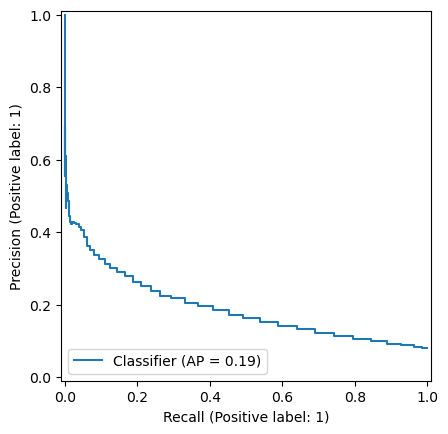

In [42]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_predictions(y_val, a)
plt.show()

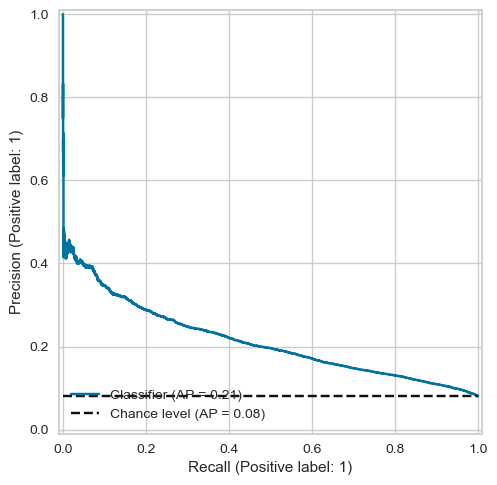

In [57]:
from sklearn.metrics import PrecisionRecallDisplay

b = y_pred_dict[1]["Logistic Regression"][:, 1]

PrecisionRecallDisplay.from_predictions(y_val, b, plot_chance_level=True)
plt.show()

In [45]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val, a)

np.float64(0.7043966140247191)

In [46]:
fpr, tpr, roc_thresholds = roc_curve(y_val, a)

desired_fpr = 0.1
# Find the index where FPR is closest to desired FPR
idx = np.argmin(np.abs(fpr - desired_fpr))
threshold = roc_thresholds[idx]

In [47]:
threshold

np.float64(0.17)

In [54]:
models[0][2]

LogisticRegression(C=10, n_jobs=-1, random_state=42, tol=0.001, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.

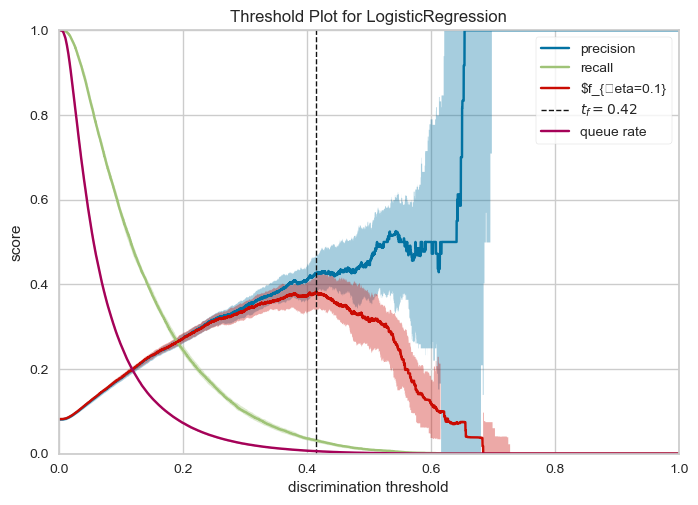

<Axes: title={'center': 'Threshold Plot for LogisticRegression'}, xlabel='discrimination threshold', ylabel='score'>

In [ ]:
from yellowbrick.classifier import DiscriminationThreshold

visualizer = DiscriminationThreshold(models[0][2], fbeta=0.1)

visualizer.fit(X_train, y_train)  # Fit the data to the visualizer
visualizer.show()

---

# MLflow

In [ ]:
import mlflow
from mlflow.models import infer_signature

In [ ]:
# Initialize MLflow
mlflow.set_tracking_uri("http://localhost:5001")
mlflow.set_experiment("MLflow try2")
# might need to run 'mlflow server --host 127.0.0.1 --port 5001' in the terminal if issues

for i, element in enumerate(tqdm(models, desc="Processing models")):
    model_name = element[0]
    params = element[1]
    model = element[2]

    # The signature wants the input (X_train) and the output (y_train_pred)
    # We fit the model so we can use .predict(X_train)
    X_sample = random.sample(X_train, k=5)
    y_sample = random.sample(y_train, k=5)
    model.fit(X_sample, y_sample)
    signature = infer_signature(X_sample, model.predict(X_sample), params=params)

    with mlflow.start_run(run_name=model_name):
        mlflow.log_params(params)

        if model_name in cv_results_dict:
            metrics = cv_results_dict[model_name]
            mlflow.log_metrics(  # we take the mean of the metric since we have 5 cv results for each model
                {
                    "roc_auc": metrics.get("test_roc_auc", []).mean(),
                    "accuracy": metrics.get("test_accuracy", []).mean(),
                    "precision": metrics.get("test_precision", []).mean(),
                    "recall": metrics.get("test_recall", []).mean(),
                    "f1": metrics.get("test_f1", []).mean(),
                    "fit_time": metrics.get("fit_time", []).mean(),
                }
            )

        mlflow.sklearn.log_model(
            model,
            "model",
            signature=signature,
            input_example=X_train,
            registered_model_name=f"{model_name}_reg",
        )

Processing models:   0%|          | 0/3 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
2025/04/09 15:14:49 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Registered model 'Logistic Regression_reg' already exists. Creating a new version of this model...
2025/04/09 15:16:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression_reg, version 8
Created version '8' of model 'Logistic Regression_reg'.
Processing models:  33%|███▎      | 1/3 [01:44<03:28, 104.07s/it]

🏃 View run Logistic Regression at: http://localhost:5001/#/experiments/201311528320565050/runs/ba14492b2f294889a9268f844556c62f
🧪 View experiment at: http://localhost:5001/#/experiments/201311528320565050


[Parallel(n_jobs=-4)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-4)]: Done  36 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-4)]: Done 100 out of 100 | elapsed:   17.9s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.5s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    1.3s finished
2025/04/09 15:16:50 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.5s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    1.3s finished
Registered model 'Random Forest_reg' already exists. Creating a new version of this model...
2025/04/09 15:18:09 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds

🏃 View run Random Forest at: http://localhost:5001/#/experiments/201311528320565050/runs/44021e6eed95485ea679ca610b1b4a62
🧪 View experiment at: http://localhost:5001/#/experiments/201311528320565050


[Parallel(n_jobs=-4)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-4)]: Done  36 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-4)]: Done 100 out of 100 | elapsed:   17.6s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.5s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    1.2s finished
2025/04/09 15:18:56 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.5s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    1.4s finished
Registered model 'Random Forest with SMOTE_reg' already exists. Creating a new version of this model...
2025/04/09 15:20:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 

🏃 View run Random Forest with SMOTE at: http://localhost:5001/#/experiments/201311528320565050/runs/b7d10d7839ad44048ed25fb6f3e79b7d
🧪 View experiment at: http://localhost:5001/#/experiments/201311528320565050


In [ ]:
# mlflow.end_run()

---

# Scoring Model

We sell credits to customers, each assigned a credit score reflecting their repayment probability. Our model calculates this probability, and we must decide the acceptable risk level for non-repayment.

In the credit sector, failed contracts are costlier than successful ones, so we aim to minimize failures. The simplest solution—not selling any contracts—guarantees no failures but isn't plausible.

We must balance risk to sustain activity, setting thresholds to reject high-risk contracts while not rejecting too many good ones. This can be modeled as an optimization problem for activity costs.

There are four possible outcomes:
- True positives/negatives: Correct predictions.
- False positives: Customers repay, but the model predicts failure.
- False negatives: Customers fail to repay, but the model predicts success.

**Steps:**

1. Set the ratio between **CFP** (Cost of False Positives) and **CFN** (Cost of False Negatives) based on business knowledge.
2. Compute the total cost and select the smallest one.

**Total Cost = (FP × CFP) + (FN × CFN)**

Since false positives are costlier, **CFP > CFN**. To find the best model, compute the total cost for each and choose the one with the lowest cost. This approach works for any **CFP** to **CFN** ratio.

In [ ]:
# Arbitrary ratio: 1 FP to 10 FN
# Convert probabilities to class labels
y_pred_classes = (y_pred >= 0.5).astype(int)
# For testing: the RandomForestClassifier is the best model


In [46]:
from sklearn.metrics import confusion_matrix

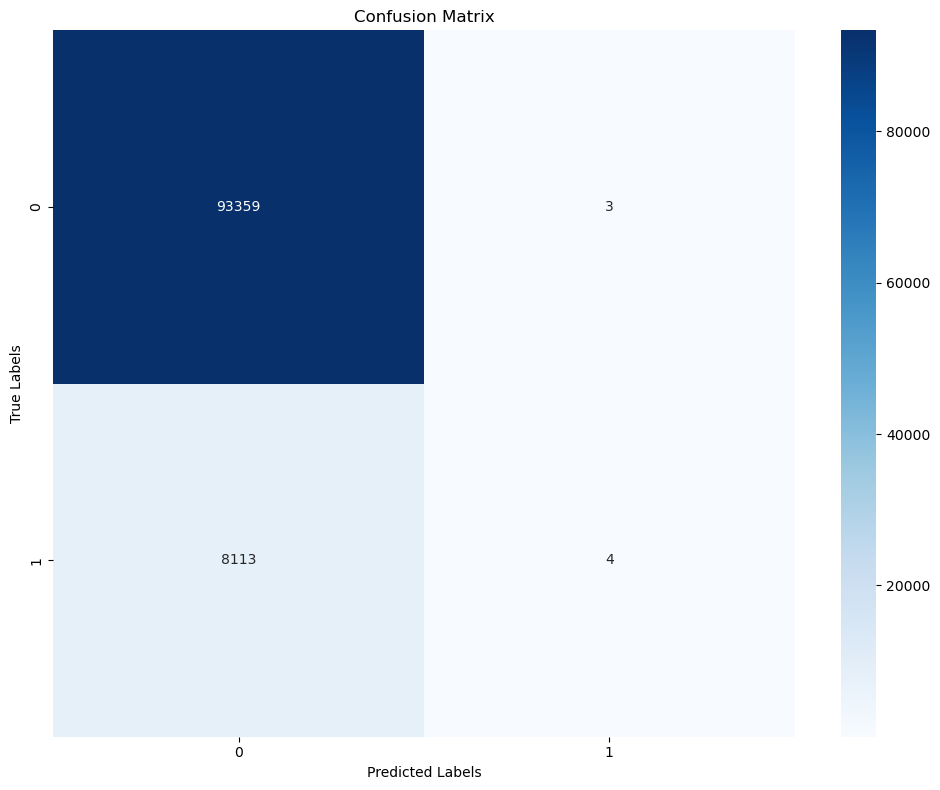

In [99]:
# Confusion matrix
cm = confusion_matrix(y_val, a)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    # xticklabels=unique_categories,
    # yticklabels=unique_categories,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
# plt.savefig("../../figures/cm_bert.png")
plt.tight_layout()
plt.show()
